In [1]:
!conda env list
!python -V
import sys
print(sys.executable)

# conda environments:
#
base                     /Applications/anaconda3
phd                   *  /Applications/anaconda3/envs/phd

Python 3.10.0
/Applications/anaconda3/envs/phd/bin/python


# Table of Contents
* [Library](#1)
    * [Model Function](#1.1)
    * [Inference Code](#1.2)
    * [Process Samples](#1.3)
    * [Plot](#1.4)
* [Murder Mystery](#2)
* [Lung](#3)
    * [Rejection Sampler](#3.1)
    * [Message Passing](#3.2)
    * [Gibbs Sampling](#3.3)
* [Toy Model](#4)
* [Toy Model 2](#5)

In [2]:
# DATA ANALYSIS
import numpy as np
import pandas as pd
import random as rand

# PLOTS
# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# OTHERS
import math
import statistics as stats
import time as t
#import pickle
import functools as fc # contains reduce

# DEBUGGER
from IPython.core.debugger import set_trace
# For executing line by line use n and 
# for step into a function use s and 
# to exit from debugging prompt use c.
# REFACTOR: uninstall jupyter packages that I installed before, not using PyCharm built in debugger


# import color blind colors
colorblind = ['#377eb8', '#ff7f00', '#4daf4a',
              '#f781bf', '#a65628', '#984ea3',
              '#999999', '#e41a1c', '#dede00']

# Library <a class="anchor" id="1"></a>

In [3]:
# Utility functions
%load utils.py
import utils

## Inference Code <a class="anchor" id="1.2"></a>
Creates a *rejection sampler*. Samples from a dist. Rejects the samples that do not match obs, accepts samples that match it

In [3]:
def inferenceCode(modelToRun, processData, obs, obs_label, n_samples = 10000):
  """
  modelToRun: model function name
  obs: inference query dict
  obs_label: observation label for graph
  """
    samples = []
    n_iter = 0

    # create joint samples
    while len(samples) < n_samples:
        sample = modelToRun()
        n_match = 0
        n_iter += 1
        # check how many keys in common
        for key in obs.keys():
            if sample[key] == obs[key]:
                n_match += 1
        # save sample if all key match
        if n_match == len(obs): samples.append(sample)
    print(n_iter,'iterations performed to get', n_samples, 'samples matching the following inference query:', obs)

    # process data
    cleanedData = processData(samples, obs_label)
    return cleanedData

## Process samples <a class="anchor" id="1.3"></a>
The samples are processed to compute the probability of the analysed event.


In [6]:
def processData(samples, obs_label):
  """
  obs_label: observation label
  """

    # find the first key of a sample
    first_key = next(iter(samples[0]))
    
    m = []
    for sample in samples:
        m.append(sample[first_key])
    
    # create data frame with output
    df = pd.Series(m, name = 'Count').value_counts()

    df = df.reset_index().rename(columns={'index':first_key})
    # normalise counts to [0,1]
    df["P(" + first_key + ")"] = df["Count"].apply(lambda x: x/df["Count"].sum())
    # add category 
    df['Label'] = obs_label
    return df

# Plot <a class="anchor" id="1.4"></a>

In [7]:
def plotFigure(df, name="Label", column=0, title="Probability for various inference queries", height=400, width=700):
    # The first column of the df should have the event name
    event = df.columns[column]
    fig = px.bar(df,
                 x=name,
                 y="P(" + event + ")",
                 color=event,
                 #barmode="group",
                 title=title,
                 width=width,
                 height=height)
    fig.update_layout(
        font_color="black",
        font_size=9,
        title_font_size=14
    )
    return fig.show()

# Murder Mystery <a class="anchor" id="2"></a>
The model outputs three variables
- `murderer`: Grey or Auburn
- `weapon`: revolver or dagger
- `hair`: true or false

The probability of success for the Benoulli trial for the variables `weapon` and `hair` are conditionnaly dependent on the outcome of `murderer`

Definitions:
- random variate: particular outcome of a random variable

Functions:
- `bernoulli.rvs(p)`: generates a random variates for a randome variable following a Bernoulli distribution of probability p

In [8]:
# Model Function
def murderMysteryModel():
    murderer = nStatesSample([0.7, 0.3], ["Auburn", "Grey"]) # testing nStatesSamples
    revolver_p = {
        "Grey": 0.9,
        "Auburn": 0.2
    }
    weapon = bernoulliSample(revolver_p.get(murderer), "revolver", "dagger")
    hair_p = {
        "Grey": 0.5,
        "Auburn": 0.05
    }
    hair = bernoulliSample(hair_p.get(murderer), True, False)
    return {
        "murderer" : murderer,
        "weapon" : weapon,
        "hair" : hair
    }
# 1 sample for the murder mystery model
murderMysteryModel()

{'murderer': 'Auburn', 'weapon': 'dagger', 'hair': False}

In [9]:
# Rejection sampler for 4 observations
m = inferenceCode(murderMysteryModel,
                  processData,
                  {}, 
                  'Prior')
mw = inferenceCode(murderMysteryModel,
                  processData,
                  {'weapon': 'revolver'}, 
                   'After observing weapon')
mh = inferenceCode(murderMysteryModel,
                  processData,
                  {'hair': True}, 
                   'After observing hair')
mwh = inferenceCode(murderMysteryModel,
                  processData,
                  {'weapon': 'revolver', 'hair': True}, 
                   'After observing weapon and hair')
# concatenate
murderers = pd.concat([m, mw, mh, mwh])
murderers

10000 iterations performed to get 10000 samples matching the following inference query: {}
24456 iterations performed to get 10000 samples matching the following inference query: {'weapon': 'revolver'}
54673 iterations performed to get 10000 samples matching the following inference query: {'hair': True}
70845 iterations performed to get 10000 samples matching the following inference query: {'weapon': 'revolver', 'hair': True}


,murderer,Count,P(murderer),Label
0,Auburn,7013,0.7013,Prior
1,Grey,2987,0.2987,Prior
0,Grey,6623,0.6623,After observing weapon
1,Auburn,3377,0.3377,After observing weapon
0,Grey,8009,0.8009,After observing hair
1,Auburn,1991,0.1991,After observing hair
0,Grey,9529,0.9529,After observing weapon and hair
1,Auburn,471,0.0471,After observing weapon and hair


In [2]:
# Plot results
plotFigure(murderers)

NameError: name 'plotFigure' is not defined

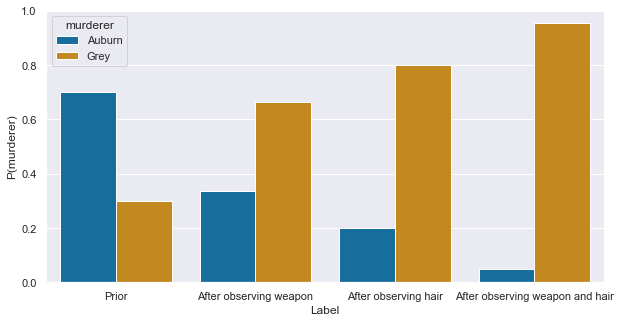

In [11]:
f = plt.figure(figsize=(10,5))
sns.set_theme(style="darkgrid",palette="colorblind")
sns.barplot(x="Label", 
            y="P(murderer)", 
            hue="murderer", 
            data=murderers)
plt.show()

## Lung <a class="anchor" id="3"></a>
### Rejection sampler <a class="anchor" id="3.1"></a>

In [12]:
# Lung Function Model
def continuousLungModel():
    inflammation = utils.threeStatesSample([0.3, 0.5, 0.2], ["absent", "small", "heavy"])
    
    wellness_p = {
        "absent": [0.01, 0.09, 0.2, 0.3, 0.5],
        "small": [0.2, 0.3, 0.3, 0.1, 0.1],
        "heavy": [0.4, 0.3, 0.15, 0.1, 0.05]
    }
    wellness = utils.nStatesSample(wellness_p.get(inflammation), [1, 2, 3, 4, 5])
    
    bacterial_load_p = {
        "absent": [0.6, 0.3, 0.1],
        "small": [0.3, 0.3, 0.4],
        "heavy": [0.1, 0.3, 0.6]
    }
    bacterial_load = utils.threeStatesSample(bacterial_load_p.get(inflammation), ["low", "medium", "high"])
    
    FEV1_p = {
        "low": [90, 10],
        "medium": [70, 20] ,
        "high": [60, 20]
    }
    
    nDecimals=2 # precision of the real world data from the spirometer
    FEV1 = utils.gaussianSample(FEV1_p.get(bacterial_load), nDecimals)
    
    return {
        "Inflammation": inflammation,
        "Wellness": wellness,
        "Bacterial load": bacterial_load,
        "FEV1": FEV1
    }
lungModel()

NameError: name 'lungModel' is not defined

In [14]:
# Test - Analysing difference between bacterial load and fev1
t0=t.time()
df1 = inferenceCode(continuousLungModel, processData, 
              {'Bacterial load': 'medium'}, 
              'After observing bacterial load',  n_samples=1000)
t1=t.time()
print("in "+str(round(t1-t0,2))+"s")
df2 = inferenceCode(continuousLungModel, processData, 
              {'Bacterial load': 'medium', 'Wellness': 5}, 
              'After observing bacterial load and wellness',  n_samples=1000)
t2=t.time()
print("in "+str(round(t2-t1,2))+"s")
df3 = inferenceCode(continuousLungModel, processData, 
              {'FEV1': 85.23}, 
              'After observing FEV1',  n_samples=1000)
t3=t.time()
print("in "+str(round(t3-t2,2))+"s")
df4 = inferenceCode(continuousLungModel, processData, 
              {'FEV1': 85.23, 'Bacterial load': 'medium'}, 
              'After observing FEV1, bacterial load', n_samples=1000)
t4=t.time()
print("in "+str(round(t4-t3,2))+"s")
df5 = inferenceCode(continuousLungModel, processData, 
              {'FEV1': 85.23, 'Bacterial load': 'medium', 'Wellness': 5}, 
              'After observing FEV1, bacterial load and wellness', n_samples=1000)
t5=t.time()
print("in "+str(round(t5-t4,2))+"s")
out = pd.concat([df1, df2, df2, df3, df5])
plotFigure(out, height=500)

3392 iterations performed to get 1000 samples matching the following inference query: {'Bacterial load': 'medium'}
in 0.03s
18344 iterations performed to get 1000 samples matching the following inference query: {'Bacterial load': 'medium', 'Wellness': 5}
in 0.1s


KeyboardInterrupt: 

#### Expected results - validated!
For variables v1, v2 with n1, n2 outcomes, the time taken scales like the total number of possibilities (n1xn2), meaning in a power law. Hence the time weight for each observation is roughly:
1. bacterial load = 3
2. bacterial load + wellness = 15 = 5x more time than 1. → validated
3. FEV1 = 20x100 = 2k → 133x more time than 2. (assuming possibilities are within the std range)
4. bacterial load + FEV1 = 3x20x100 = 6k → 3x more time than 3.
5. bacterial load + wellness + FEV1 = 3x5x20x100 = 30k → 15x more time than 3 or 5x more time than 4.

#### Results
Looking at BRDataDemographics, the (mean, avg) FEV1% variance is (5,4). Hence simulating a std dev of 10 (hence, 20x100 possibilities) is reasonnable.
Number of continuous variables, time of inference: 1 takes 30", 2 takes 1', 120 takes 1h, 
Note: this is to get 1k samples

In [ ]:
# plot time of computations vs number of continuous vars
nVar = np.arange(1,20)
time1Var = 26 # seconds
nPossibilitiesPerVar = 2000
time = time1Var * pow(nPossibilitiesPerVar, nVar-1)/(3600*24)

In [ ]:
fig = px.scatter(x=nVar, y=time, labels={'x':'Number of continuous variables', 'y':'Model inference time in days (with my personal computer)'}, 
                 log_y=True, height=600)
fig.show()

### Belief propagation <a class="anchor" id="3.2"></a>
Also known as message passing

In [23]:
# Lung Function Model
class lungModel:
    
    # Names
    """
    i: inflammation
    bl: bacterial load
    w: wellness
    """
    # Marginal distributions
    marginal_i = {
        "absent": 0.3,
        "small": 0.5,
        "heavy": 0.2
    }
    # Conditional probability table (cpt) of varB knowing varA
    cpt_bl_i = {
        "absent": {
            "low": 0.6,
            "medium": 0.2,
            "high": 0.2
        },
        "small": {
            "low": 0.3,
            "medium": 0.3,
            "high": 0.4
        },
        "heavy": {
            "low": 0.1,
            "medium": 0.3,
            "high": 0.6
        }
    }
    cpt_w_i = {
        "absent": {
            1: 0.01,
            2: 0.09,
            3: 0.2,
            4: 0.3,
            5: 0.4
        },
        "small": {
            1: 0.2,
            2: 0.3,
            3: 0.3,
            4: 0.1,
            5: 0.1
        },
        "heavy": {
            1: 0.4,
            2: 0.3,
            3: 0.15,
            4: 0.1,
            5: 0.05
        }
    }
    cpt_FEV1_bl = {
        'low': {
            'low': 0.6,
            'medium': 0.3,
            'high': 0.2,
        },
        'medium': {
            'low': 0.3,
            'medium': 0.4,
            'high': 0.3,
        },
        'high': {
            'low': 0.1,
            'medium': 0.4,
            'high': 0.5,
        }
    }
    
    def sample(self):
        inflammation = utils.threeStatesSample(list(self.marginal_i.values()),
                                               list(self.marginal_i.keys()))
        
        wellness = utils.nStatesSample(list(self.cpt_w_i[inflammation].values()),
                                 list(self.cpt_w_i[inflammation].keys()))
        
        bacterial_load = utils.threeStatesSample(list(self.cpt_bl_i[inflammation].values()),
                                            list(self.cpt_bl_i[inflammation].keys()))
        
        FEV1 = utils.threeStatesSample(list(self.cpt_FEV1_bl[bacterial_load].values()),
                                list(self.cpt_FEV1_bl[bacterial_load].keys()))
        
        return {
            "Inflammation": inflammation,
            "Wellness": wellness,
            "Bacterial load": bacterial_load,
            "FEV1": FEV1
        }
model = lungModel()
model.sample()

{'Inflammation': 'absent',
 'Wellness': 4,
 'Bacterial load': 'low',
 'FEV1': 'high'}

In [82]:
# inference code
def get_cpt_obs(obs_B, cpt_B_A):

    cpt_B_A_bis = cpt_B_A
    for key_A, items_B in cpt_B_A.items():
        for key_B, p_B in items_B.items():
            # observed variable has probability 1, unobserved are 0
            if key_B != obs_B: cpt_B_A_bis[key_A][key_B] = 0
            else: cpt_B_A_bis[key_A][key_B] = p_B
    
    return cpt_B_A_bis
    
def get_second_level_keys(cpt_B_A):
    """
    returns a dict with second level keys and values set to 0
    """
    return {key : 0 for key in cpt_B_A[next(iter(cpt_B_A))]}

def get_first_level_keys(cpt_B_A):
    return {key : 0 for key in cpt_B_A.keys()}
    
def marginalise(cpt_B_A, dist_A):
    """
    marginalise out B out of cpt_B_A
    TODO: implement case where A is not marginal (recursion?)
    """
    
    dist_B = get_second_level_keys(cpt_B_A)
    # P(B) = sum_A(P(B | A) * P(A))
    for key_A, B_A in cpt_B_A.items():
        for key_B, B_value in B_A.items():
            dist_B[key_B] += B_value * dist_A[key_A]
    
    return dist_B

# factor node message
def message_down(dist, disp=1, label_A='A'):
    """
    dist: marginal distribution
    """
    if disp==1: print('marginal distribution: P(', label_A, ') =', dist, '\n')
    print("message down: ", dist)
    return dist

def message_up(A_dist, cpt_B_A, disp=1, label_A='A', label_B='B'):
    
    # compute normalisers, sum_B(P(B|A) * P(A))
    normalisers = get_first_level_keys(cpt_B_A)
    print(cpt_B_A)
    for key_A, items_B in cpt_B_A.items():
        for key_B, p_B_A in items_B.items():
            normalisers[key_A] += p_B_A * A_dist[key_A]

    normaliser = sum(list(normalisers.values()))
    
    # compute posteriors P(A|B) = P(B|A) * P(A) / sum_B(P(B|A))
    posteriors = get_first_level_keys(cpt_B_A)
    for key_A, items_B in cpt_B_A.items():
        for key_B, p_B_A in items_B.items():
            if p_B_A != 0:
                posteriors[key_A] = p_B_A * A_dist[key_A] / normaliser
    print("posteriors: ",posteriors)
    return posteriors

# variable node message
def propagate_belief(messages):
    # Multiply all messages
    beliefs=[]
    for key in messages[0].keys():
        belief=1
        for message in messages:
            print("message",message[key])
            belief *= message[key]
        print("belief", belief)
        beliefs.append(belief)
    
    # Normalise and format
    normalised_beliefs = utils.normalise_list(beliefs)
    p_A_given_B = dict(zip(messages[0].keys(), normalised_beliefs))
    
    print('Result of belief propagation:', p_A_given_B)
    return p_A_given_B


In [87]:
# define model
m = lungModel()

# CASE 1

obs_bacterial_load = 'medium'

cpt_bl_obs_i = get_cpt_obs(obs_bacterial_load,m.cpt_bl_i)

# belief propagation
i_bl = message_up(m.marginal_i, cpt_bl_obs_i)

i = message_down(m.marginal_i)

belief1 = propagate_belief([i_bl, i])


{'absent': {'low': 0, 'medium': 0.2, 'high': 0}, 'small': {'low': 0, 'medium': 0.3, 'high': 0}, 'heavy': {'low': 0, 'medium': 0.3, 'high': 0}}
posteriors:  {'absent': 0.2222222222222222, 'small': 0.5555555555555555, 'heavy': 0.2222222222222222}
marginal distribution: P( A ) = {'absent': 0.3, 'small': 0.5, 'heavy': 0.2} 

message down:  {'absent': 0.3, 'small': 0.5, 'heavy': 0.2}
message 0.2222222222222222
message 0.3
belief 0.06666666666666667
message 0.5555555555555555
message 0.5
belief 0.27777777777777773
message 0.2222222222222222
message 0.2
belief 0.044444444444444446
Result of belief propagation: {'absent': 0.17142857142857146, 'small': 0.7142857142857143, 'heavy': 0.11428571428571431}


In [86]:
# CASE 2

obs_bacterial_load = 'medium'
obs_wellness = 1

cpt_bl_obs_i = get_cpt_obs(obs_bacterial_load,m.cpt_bl_i)
cpt_w_obs_i = get_cpt_obs(obs_wellness,m.cpt_w_i)

# belief propagation
i_bl = message_up(m.marginal_i, cpt_bl_obs_i)
i_w = message_up(m.marginal_i, cpt_w_obs_i)
i = message_down(m.marginal_i)

belief1 = propagate_belief([i_bl, i_w, i])

{'absent': {'low': 0, 'medium': 0.2, 'high': 0}, 'small': {'low': 0, 'medium': 0.3, 'high': 0}, 'heavy': {'low': 0, 'medium': 0.3, 'high': 0}}
posteriors:  {'absent': 0.2222222222222222, 'small': 0.5555555555555555, 'heavy': 0.2222222222222222}
{'absent': {1: 0.01, 2: 0, 3: 0, 4: 0, 5: 0}, 'small': {1: 0.2, 2: 0, 3: 0, 4: 0, 5: 0}, 'heavy': {1: 0.4, 2: 0, 3: 0, 4: 0, 5: 0}}
posteriors:  {'absent': 0.016393442622950817, 'small': 0.5464480874316939, 'heavy': 0.43715846994535523}
marginal distribution: P( A ) = {'absent': 0.3, 'small': 0.5, 'heavy': 0.2} 

message down:  {'absent': 0.3, 'small': 0.5, 'heavy': 0.2}
message 0.2222222222222222
message 0.016393442622950817
message 0.3
belief 0.0010928961748633878
message 0.5555555555555555
message 0.5464480874316939
message 0.5
belief 0.15179113539769273
message 0.2222222222222222
message 0.43715846994535523
message 0.2
belief 0.01942926533090468
Result of belief propagation: {'absent': 0.006342494714587738, 'small': 0.8809020436927413, 'heav

In [ ]:
# CASE 3
# observations
obs_FEV1 = 'low'
obs_wellness = 1

cpt_bl_obs_i = get_cpt_obs(obs_bacterial_load, m.cpt_FEV1_bl)

# belief propagation
bl_FEV1 = message_up(m.cpt_FEV1_bl, cpt_bl_obs_i)
i_w = message_up(m.marginal_i, m.cpt_w_i, obs_wellness)
i = message_down(m.marginal_i)

belief1 = propagate_belief([i_bl, i_w, i])

## Gibbs sampling <a class="anchor" id="3.3"></a>

In [ ]:
# Gibbs inference code
def gibbs_inference_code(target_X, target_Y, modelToRun=lungModel, n=100000):


    # Random initialisation
    sample = modelToRun()
    i = [sample[target_X]]
    b = [sample[target_Y]]
    print('Initial state:', I, '=', i, ',', B, '=', b)

    # Loop
    # TODO  review function arguments to avoid global variables
    for j in np.arange(n):
        b.append(threeStatesSample(bacterial_load_p.get(i[j]), ["low", "medium", "high"]))
        i_posteriors = compute_posterior(I, B, b[j+1], conditional_probability_table, disp=0)
        i.append(threeStatesSample([i_posteriors[key] for key in i_posteriors.keys()], list(i_posteriors.keys())))

    return b, i

# Data processing
def get_marginal(name, list):
    '''
    name: identifier
    list: a list of values
    output: distinct values count in list, and related proportions (probability estimate)
    '''
    marginal = pd.DataFrame(data={name: list})
    marginal = pd.DataFrame(data={'count': marginal.value_counts()}).reset_index()
    marginal['P(count)'] = marginal['count']/marginal['count'].sum()
    
    return marginal

In [ ]:
# Gibbs sampling implementation for two variables

# Variables
I = 'Inflammation'
B = 'Bacterial load'
    
n_high=100000; n_low=1000
b, i = gibbs_inference_code(I, B, n=n_high)
b_fuzzy, i_fuzzy = gibbs_inference_code(I, B, n=n_low)

# Marginal distribution of inflammation
i_marginal = get_marginal(I, i)
i_marginal_fuzzy = get_marginal(I, i_fuzzy)
i_marginal

In [ ]:
# Marginal distribution of bacterial load
b_marginal = get_marginal(B, b)
b_marginal

In [ ]:
plotFigure(i_marginal, I, column=1, title="Marginal distribution for inflammation for "+str(n_high)+" iterations")
plotFigure(i_marginal_fuzzy, I, column=1, title="Marginal distribution for inflammation "+str(n_low)+" iterations")
plotFigure(b_marginal, B, column=1, title="Marginal distribution for inflammation for "+str(n_high)+" iterations")

# Toy Model <a class="anchor" id="4"></a>
## Set up
A coin is tricked to give heads with a probability p. The coin is tossed n times and we record the number of heads. We repeat this a couple of times to get a series of number of heads recorded (nTrials). We then plot the distribution of the number of heads observed.

In [ ]:
def toyModel(p, n=10):
    '''
    p: probability of coin toss
    n: number of coin tosses
    return p and number of observed heads
    '''
    samples=[]
    for _ in range(n):
        samples.append(bernoulliSample(p, "heads", "tails"))
    nHeads = samples.count("heads")
    return nHeads

In [ ]:
# plot function
def processToyModel(p = rand.random(), nToss = 10, nTrials=100):
    coin = pd.DataFrame([toyModel(p=p, n=nToss) for _ in range(nTrials)], 
                 columns=["number of heads observed"])
    coin["p"] = p
    
    fig = px.histogram(coin, x='number of heads observed', height=300, 
             range_x=(0,nToss),
             title="Distribution after "+str(nToss)+" tosses")
    return fig, coin


In [ ]:
p = rand.random()
nToss1 = 10
nToss2 = 1000
fig1, data1 = processToyModel(p = p, nToss = nToss1, nTrials=20)
fig2, data2 = processToyModel(p = p, nToss = nToss2, nTrials=20)
fig1.show()
print("Inferred probability p = ", round(stats.mean(data1["number of heads observed"])/nToss1,3))
fig2.show()
print("Inferred probability p = ", round(stats.mean(data2["number of heads observed"])/nToss2,3))
print("Unknown probability p =", round(p,3))


## Observations
- When the number of tosses increases, the dispersion of the number of heads observed gets smaller. When nToss → ∞, the distribution converges to a point mass, which is the unknown probability.
- The number of trials controls the quality of the distribution. The higher nTrials, the smoother the distribution.

## Conclusion
One can infer the probability of an event by looking at the distribution of its observations.
The more observations are made, the more accurate is the inferred probability.

$ P(toss\ outcome\ =\ head) = \frac{avg_{trials}(Heads\ count)}{Number\ of\ tosses\ per\ trial} $

**Parallel with lungs**: we want to infer the probability that a human has an FEV1 over 103%. Take a group of people. For each person, measure the FEV1 for n days. The inferred probability is:

$ P(FEV_1>103\%) = \frac{avg_{participants}(FEV1>103\%\ count)}{Number\ of\ measurements} $

# Toy Model 2 <a class="anchor" id="5"></a>
- Observations: number of heads M and number of tosses N per trial
- For each trial p(heads) ~ U(0,1)
- We reject the trial if M is not matched
- Have T points in the distribution
- Plot the distribution of p

Expectations: for M=7, N=8, p will be centered close to 7/8 (=M/N) if sufficient trials are done.
1. M=0, distribution is linear with max on p=0 and 0 on p=1
2. The distribution of p should be close to M/N
3. The higher N, the more reproductible the experiment

Results:
- The higher N, the lower the variance of p = the lower the uncertainty of p
- Each sample is drawn from a Beta distribution with parameters M and N
    - M/N controls the mean
    - N controls the spread/dispersion

In [ ]:
def processToyModel2(M=7 , N=8, T=10):
    i=0
    p = []
    t0=t.time()
    while(len(p) < T):
        i=i+1
        p_temp = rand.random()
        m = toyModel(p_temp, N)
        if M == m: p.append(p_temp)
    t1=t.time()
    fig = px.histogram(p, height=300,
             title=str(i)+" trials in "+str(round(t1-t0,1))+"s to obtain "+str(T)+" datapoints for "+str(N)+" tosses and "+str(M)+" heads",
            range_x=(0,1))
    return fig

In [ ]:
fig1 = processToyModel2(M=7 , N=8, T=1000)
fig1.show()
fig2 = processToyModel2(M=0 , N=8, T=1000)
fig2.show()
fig3 = processToyModel2(M=0 , N=30, T=1000)
fig3.show()
fig4 = processToyModel2(M=0 , N=8, T=10)
fig4.show()